In [16]:
import sys
sys.path.append('../code/functions')
sys.path.append('../../pipeline_1/code/functions')

import cv2
import glob
import random
import numpy as np
import tiffIO as io
import scipy.io as sio
import matplotlib.pyplot as plt
import connectLib as cLib
import matplotlib.lines as mlines

from qaLib import visDiff
from qaLib import precision_recall_f1
from scipy import ndimage
from cluster import Cluster
from scipy.ndimage.filters import convolve
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.morphology import remove_small_objects
from skimage.measure import label

In [2]:
procData = []
for mat in glob.glob('collman14/collman14v2/*_p1.mat'):
    name = mat[22:-7]
    print name
    rawData = sio.loadmat(mat)
    try:
        npData = np.rollaxis(rawData[name], 2, 0)
        procData.append([name, npData])
    except:
        print 'rip'


NR1
gephyrin
VGAT
synapsin
PSDr
VGluT1
annotation


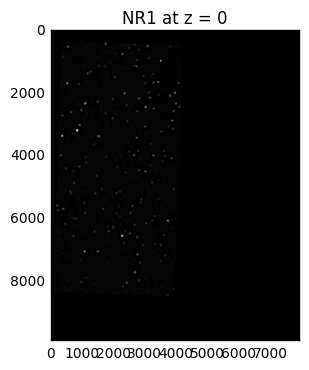

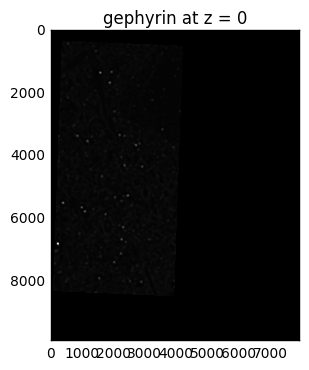

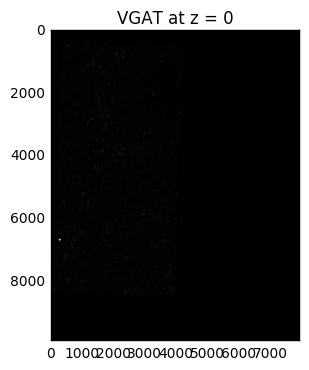

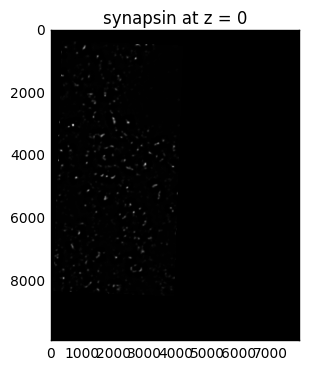

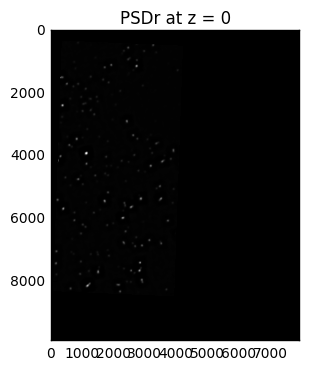

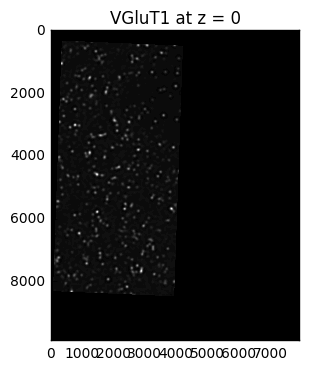

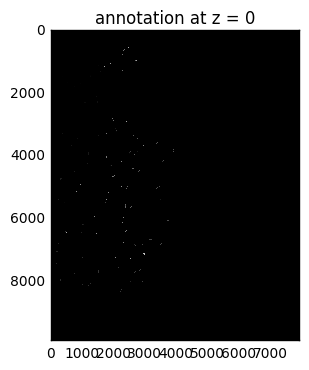

In [3]:
for dataSet in procData:
    plt.figure()
    plt.imshow(dataSet[1][0], cmap='gray')
    plt.title(str(dataSet[0]) + ' at z = 0')
    plt.show()

In [9]:
def visVolDiff(a, b):
    fig = plt.figure()
    plt.imshow(visDiff(a, b))
    plt.title("Disparity Between Predictions And Labels")

    blue_line = mlines.Line2D([], [], color='blue',markersize=15, label='Blue line')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Green line')
    red_line = mlines.Line2D([], [], color='red', markersize=15, label='Green line')


    handles = [red_line, blue_line, green_line]
    labels = ["Predictions Only", "Labels Only", "Both Predictions and Labels"]
    fig.legend(handles=handles, labels=labels, loc=3)
    plt.show()

In [6]:
testData = procData[4][1]
labelData = procData[6][1]

In [7]:
otsuOut = cLib.otsuVox(testData)

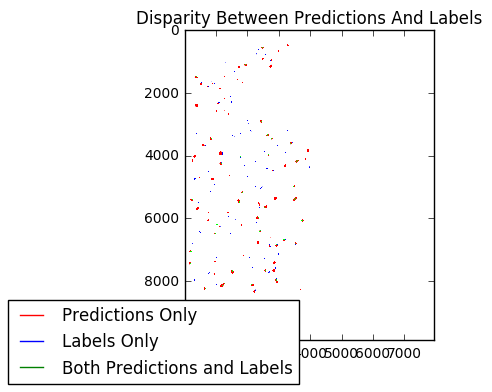

In [10]:
visVolDiff(otsuOut[0], labelData[0])

In [12]:
predClusters = cLib.clusterThresh(otsuOut, 0, 100000000)

In [13]:
lClusters = cLib.clusterThresh(labelData, 0, 100000000)

In [17]:
precision_recall_f1(lClusters, predClusters)

(0.6414342629482072, 0.6284916201117319, 0.6348969880732256)

In [14]:
clusterList = predClusters
aveList = []
maxList = []
for cluster in clusterList:
    curClusterDist = []
    for member in cluster.members:
        curClusterDist.append(testData[member[0]][member[1]][member[2]])
    aveList.append(np.mean(curClusterDist))
    maxList.append(np.max(curClusterDist))

#thresh = threshold_otsu(np.array(maxList))
randClusterDist = []
for i in range(100000):
    point = [int(random.random()*testData.shape[0]), int(random.random()*testData.shape[1]), int(random.random()*testData.shape[2])]
    randClusterDist.append(testData[point[0]][point[1]][point[2]])

mu = np.average(randClusterDist)
sigma = np.std(randClusterDist)
finalClusters = []
for i in range(len(maxList)): #this is bad and i should feel bad
    if (aveList[i] - mu)/float(sigma) > 6:
        finalClusters.append(clusterList[i])

In [18]:
outVol = np.zeros_like(testData)
print len(finalClusters)
for cluster in finalClusters:
    for member in cluster.members:
        outVol[member[0]][member[1]][member[2]] = 1
        
print np.count_nonzero(outVol)/float(outVol.shape[0] * outVol.shape[1] * outVol.shape[2]) 

579
0.00405251734281


In [19]:
precision_recall_f1(lClusters, finalClusters)

(0.7047184170471842, 0.6075418994413407, 0.6525320628605401)

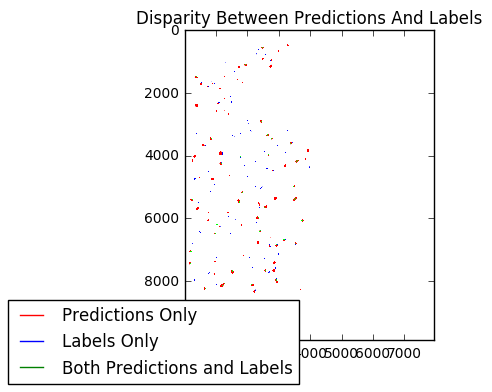

In [21]:
visVolDiff(outVol[0], labelData[0])